# Climate Services workshop

This notebook and workshop was developed for the [ICEM 2023 conference](https://www.wemcouncil.org/wp/icem-2023-speakers-program), presented at the [Climate Services workshop](https://linktr.ee/ICEM23ClimateServices) using [`jupyter RISE`](https://rise.readthedocs.io/en/stable), and intended to work on https://mybinder.org.

*Advanced `python` users: see the github repo README for more instructions with setup and installation if running on your own device.*

In [1]:
%%capture
# ensure that all package requirements are met
!pip install pandas xarray rioxarray matplotlib rasterio

In [2]:
# import relevant libraries and functions not built-in to python

# numpy is used for working with arrays, and has many other uses
import numpy as np

# pandas is a really nice tool for working with 2D arrays and reading CSV files
import pandas as pd

# xarray has more features than pandas, and can handle
# more complex data structures and types (including netcdf)
import xarray as xr
import rioxarray as rx

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [3]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# plotting and styling

# matplotlib is a general purpose plotting backend
import matplotlib.pyplot as plt

# plotting large datasets
import rasterio
from rasterio.plot import show

# [optional] use the mplcyberpunk theme, and pass if module not found
try:
    # theme can be installed with: pip install mplcyberpunk
    import mplcyberpunk
    plt.style.use("cyberpunk")
except:
    pass

# change default plot size
plt.rcParams["figure.figsize"] = (12, 3.8)

<center><h1><a id="top">Workshop on Weather and Climate Services</a></h1></center>

<center>Using weather and climate data to support decision-making in the energy sector</center>

<center>
    <b>icem 2023</b> 7th International Conference Energy & Meteorology:
    <br>
    <i>Towards Climate-Resilient Energy Systems</i>
</center>

<br><br>
<div style="width:14%;float: left">
<a href="https://linktr.ee/ICEM23ClimateServices"><img src="github_qr.png"></a>
</div>
<br><br>&nbsp;&nbsp;&nbsp;&nbsp;
<a href="https://linktr.ee/ICEM23ClimateServices">https://linktr.ee/ICEM23ClimateServices</a>


## Programme

*Tuesday 27th June 16:15-18:00 CEST*  
**Convenors: James Fallon, Jake Badger and Justin Sharp (remote)**    
**Panelists: Falguni Patadia, Frank Kaspar, Gabriel Perez**

| Time | Activity | Speaker |
| --- | --- | --- |
| 16:15 | Introduction | Jake |
| 16:20 | Overview of Live Climate Services | Jake |
| 16:40 | Interactive Session: Climate Services Notebook | James |
| 17:20 | Discussion: the "Next Generation" of Climate Services | Panellists |
| 17:55 | Closing remarks | Jake & James |

## About these slides

View as `PDF` / `html` or run `ipynb` with instructions at:

<table width=100% height=100% style="font-size: 38px";><tr><td width=30%><a href="https://github.com/jfallon1997/ICEM-2023-ClimateServicesWorkshop"><center><img src="github_qr.png" width="60%"></center></a></td><td width=70%><center><a href="https://linktr.ee/ICEM23ClimateServices">https://linktr.ee/ICEM23ClimateServices</a><br><br><a href="https://github.com/jfallon1997/ICEM-2023-ClimateServicesWorkshop">https://github.com/jfallon1997/<br>ICEM-2023-ClimateServicesWorkshop</a></center></td></tr></table>

## Introduction



### "what is a climate service"

*A decision aide derived from climate information*<sup>[1](https://public.wmo.int/en/bulletin/what-do-we-mean-climate-services)</sup>

Example slides and schematics here: <https://www.wemcouncil.org/TALKS/EEA_Troccoli_Copenhagen_Sep2018.pdf>



#### Definition of Climate Services adopted by the ScienceDirect Climate Services journal (open access)

"the transformation of climate-related data - together with other relevant information - into customized products such as projections, forecasts, information, trends, economic analysis, assessments (including technology assessment), counselling on best practices development and evaluation of solutions and any other services in relation to climate that may be use for the society at large."

source: European Commission's Roadmap for Climate Services (2015).

### "what is a climate service used for"

* see previously linked slides - take some examples
* any examples from submitted abstracts?
* other ideas?

### "what we will cover today"

* how to **access and use** some climate services
* exploring the **impact chain**: from weather data to energy variables
* **common misconceptions** / things to be aware of!
* hear from expert panellists
* discussion on the next generation of weather & climate services

## Overview of Live Climate Services

**todo: insert panelists names & affiliations**

### eg. COPERNICUS API / ECEM / C4E

<center><img src="screenshots/COPERNICUS_ECEM_demo_1.png" width="60%"></center>

### eg. NASA POWER

<center><img src="screenshots/NASA_POWER_demo_1.png" width="80%"></center>

## Interactive Session Part 1: Working with Meteorological Data

We will show how to read in wind data - but a similar process can be considered for solar irradiance, temperature, and other energy-relevant variables

### Downloading data...

In this example, we use the **NASA POWER DAVe** tool to extract **1 month of hourly 50m wind speed data** from **Hudson Bay**

*There are over 21 unique energy variables across categories of "solar fluxes and related", "temperatures", "humidity/precipitation", "wind/pressure" with additional customisation such as pressure correction and elevation changes available*

<center><img src="screenshots/NASA_POWER_demo_2.png" width="80%"></center>

### Read in a reanalysis dataset

Now that we have downloaded our data, we use `xarray` to open the dataset

In [5]:
# read in the dataset
wind50m_reanalysis = xr.open_dataset("datasets/reanalysis/POWER_Point_Hourly_20220129_20230128_039d48N_073d59W_LST.nc")["WS50M"]

In [6]:
# dataset overview
wind50m_reanalysis

<xarray.DataArray 'WS50M' (time: 8760, lat: 1, lon: 1)>
[8760 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2022-01-28T19:00:00 ... 2023-01-28T18:00:00
  * lat      (lat) float32 39.48
  * lon      (lon) float32 -73.59
Attributes:
    units:          m/s
    long_name:      Wind_Speed_at_50_Meters
    standard_name:  Wind Speed at 50 Meters

### Observations dataset

We will use LiDAR measurements contrasted against the already plotted reanalysis matches to see how well reanalysis matches up with in-situ measurements...

In [7]:
def read_csv_lidar(fpath: str, field: str, na_value: float=9990.) -> pd.DataFrame:
    """Read CSV LiDAR data using pandas"""
    # read in CSV data
    df = pd.read_csv(fname, parse_dates=["timestamp"], index_col=0, sep=r",\ ", usecols=["timestamp", field], dtype=float)
   
    # handle nan values (can be 9998 or 9999 - remove anything 9990 or greater)
    df[df[field] > na_value] = np.nan
    
    # return DataFrame
    return df

In [8]:
# read in a lidar dataset
## New York Bight LiDAR Buoy data
## https://oswbuoysny.resourcepanorama.dnv.com
fname = "datasets/NYSERDA Floating LiDAR Buoy Data/E05_Hudson_South_West_10_min_avg_20220129_20230128.csv"
wind58m_lidar = read_csv_lidar(fname, "lidar_lidar58m_Z10_HorizWS")

### Plot windspeeds

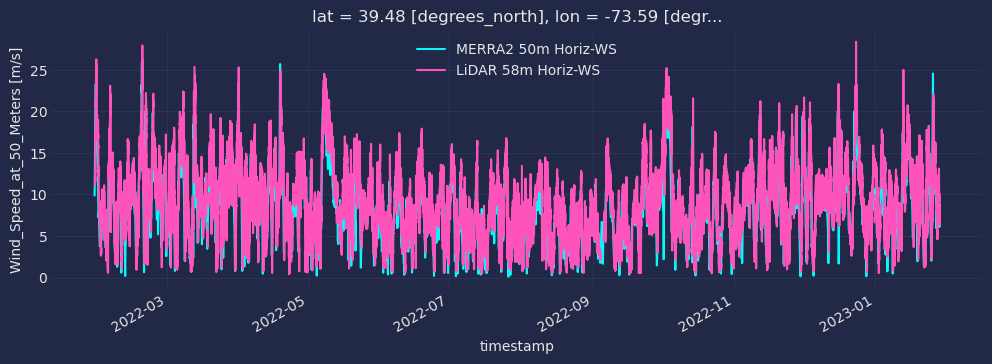

In [9]:
# plot each timeseries
fig, ax = plt.subplots()
wind50m_reanalysis.plot(ax=ax)
lines = wind58m_lidar.plot(ax=ax).lines

# add x and y limit code here
#plt.gca().set_xlim("2022-04-15", "2022-11-01")

plt.legend(lines, ["MERRA2 50m Horiz-WS", "LiDAR 58m Horiz-WS"]);

## Interactive Session Part 2: Spatial Data

APIs to access ready made geotiff files on DTU's Global Wind Atlas

In [10]:
# JABA: examples of APIs to access ready made geotiff files on DTU's Global Wind Atlas
#mmap_name = 'https://globalwindatlas.info/api/gis/country/DNK/wind-speed/100'
#mmap_name = 'https://globalwindatlas.info/api/gis/country/DNK/elevation_w_bathymetry/'
#mmap_name = 'https://globalwindatlas.info/api/gis/country/ITA/wind-speed/100'

## Load datasets

In [11]:
# JABA: example custom region of interest ("area-1") defined on GWA webpage,
# JABA: and wind speed at different heights above surface made as geostiff data and downloaded
mmap_name10 = "datasets/GWA/area_1_wind-speed_10m.tif"
mmap_name50 = "datasets/GWA/area_1_wind-speed_50m.tif"
mmap_name100 = "datasets/GWA/area_1_wind-speed_100m.tif"
mmap_name150 = "datasets/GWA/area_1_wind-speed_150m.tif"
mmap_name200 = "datasets/GWA/area_1_wind-speed_200m.tif"

## Visualise datasets

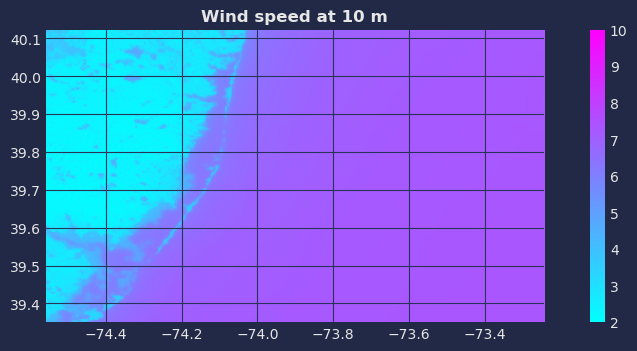

In [12]:
# JABA: 10 m data
fig, ax = plt.subplots()
dataset10 = rasterio.open(mmap_name10)
im = show((dataset10, 1), ax=ax, title='Wind speed at 10 m', vmin=2, vmax=10)
fig.colorbar(im.get_images()[0], ax=ax);

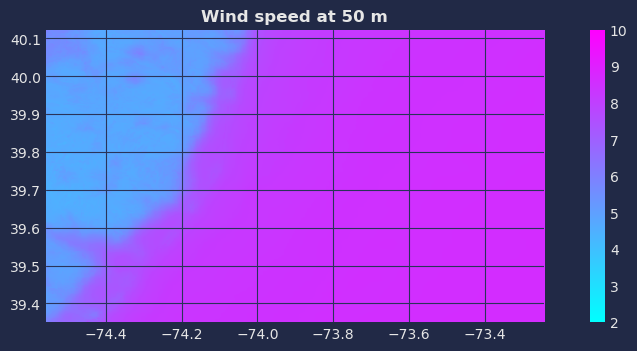

In [13]:
# JABA: 50 m data
fig, ax = plt.subplots()
dataset50 = rasterio.open(mmap_name50)
im = show((dataset50,1), ax=ax, title='Wind speed at 50 m', vmin=2, vmax=10)
fig.colorbar(im.get_images()[0], ax=ax);

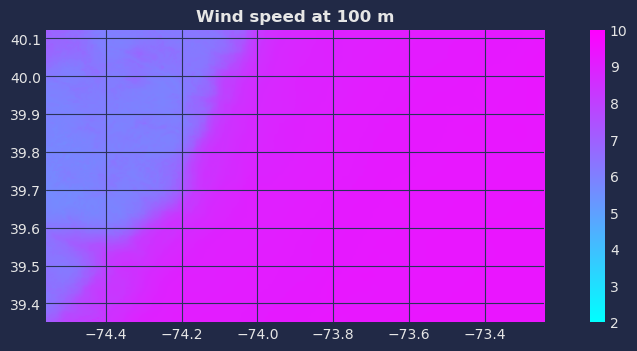

In [14]:
# JABA: 100 m data
fig, ax = plt.subplots()
dataset100 = rasterio.open(mmap_name100)
im = show((dataset100,1), ax=ax, title='Wind speed at 100 m', vmin=2, vmax=10)
fig.colorbar(im.get_images()[0], ax=ax);

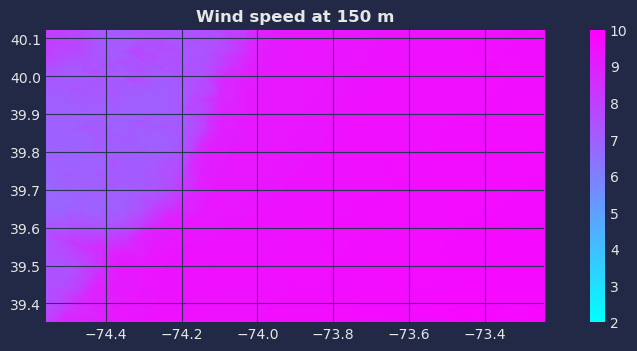

In [15]:
# JABA: 150 m data
fig, ax = plt.subplots()
dataset150 = rasterio.open(mmap_name150)
im = show((dataset150,1), ax=ax, title='Wind speed at 150 m', vmin=2, vmax=10)
fig.colorbar(im.get_images()[0], ax=ax);

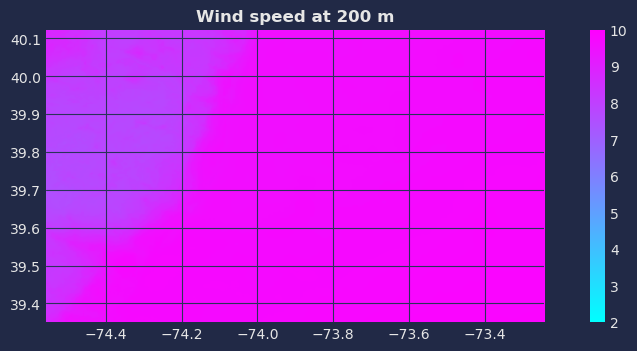

In [16]:
# JABA: 200 m data
fig, ax = plt.subplots()
dataset200 = rasterio.open(mmap_name200)
im = show((dataset200, 1), ax=ax, title='Wind speed at 200 m', vmin=2, vmax=10)
fig.colorbar(im.get_images()[0], ax=ax);

## Make transect measurement

In [17]:
# open datasets with xarray
ds10 = xr.open_dataset(mmap_name10, engine='rasterio')
ds50 = xr.open_dataset(mmap_name50, engine='rasterio')
ds100 = xr.open_dataset(mmap_name100, engine='rasterio')
ds150 = xr.open_dataset(mmap_name150, engine='rasterio')
ds200 = xr.open_dataset(mmap_name200, engine='rasterio')

In [ ]:
ds10

In [ ]:
ds10.x.mean(), ds10.y.mean()

In [18]:
# Make transect at measurement latitude.
windspeed10 = ds10.band_data
windspeed50 = ds50.band_data
windspeed100 = ds100.band_data
windspeed150 = ds150.band_data
windspeed200 = ds200.band_data

# calculate mean of reanlsysis data, this will be used in the transect plot
wind50m_reanalysis_mean=np.mean(wind50m_reanalysis)
#wind50m_reanalysis_mean

# calculate mean of lidar data, this will be used in the transect plot
wind58m_lidar_mean=np.mean(wind58m_lidar)
#wind58m_lidar_mean

 
# JABA: create a transect at the measurement location (lon_meas, lat_meas)
#lon_meas = -74.0 # teest
#lat_meas = 40.0 # test
lon_meas=-73.59
lat_meas=39.48


# JABA: put in the mean value here for the measured and reanalysis data
#data_meas = 6.0
#data_rean = 6.9
data_meas = wind58m_lidar_mean
data_rean = wind50m_reanalysis_mean

 
lat_trans = lat_meas

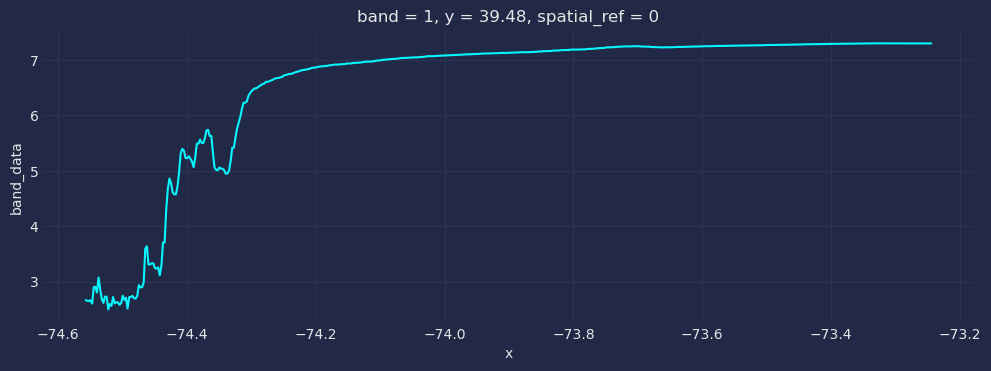

In [19]:
# plot 10m windspeed
windspeed10_1d=windspeed10.sel(band=1, y=lat_trans, method='nearest')
windspeed10_1d.plot();

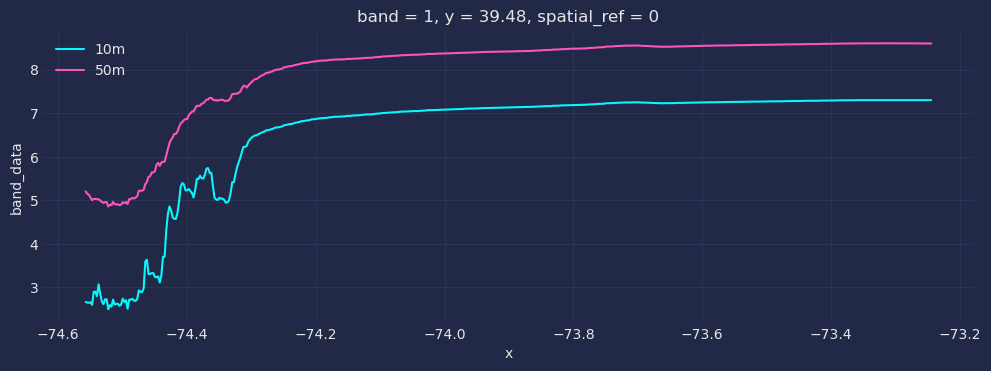

In [20]:
# add 50m windspeed
windspeed50_1d=windspeed50.sel(band=1, y=lat_trans, method='nearest')

windspeed10_1d.plot(label="10m")
windspeed50_1d.plot(label="50m")

plt.legend();

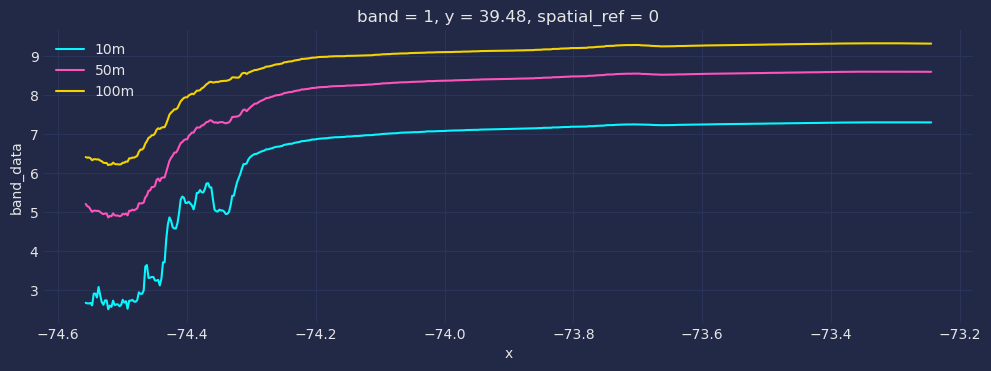

In [21]:
# add 100m windspeed
windspeed100_1d=windspeed100.sel(band=1, y=lat_trans, method='nearest')

windspeed10_1d.plot(label="10m")
windspeed50_1d.plot(label="50m")
windspeed100_1d.plot(label="100m")

plt.legend();

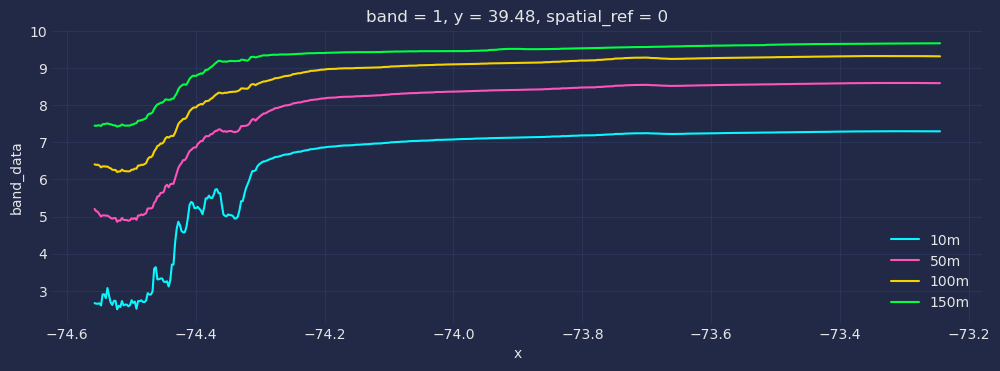

In [22]:
# add 150m windspeed
windspeed150_1d=windspeed150.sel(band=1, y=lat_trans, method='nearest')

windspeed10_1d.plot(label="10m")
windspeed50_1d.plot(label="50m")
windspeed100_1d.plot(label="100m")
windspeed150_1d.plot(label="150m")

plt.legend();

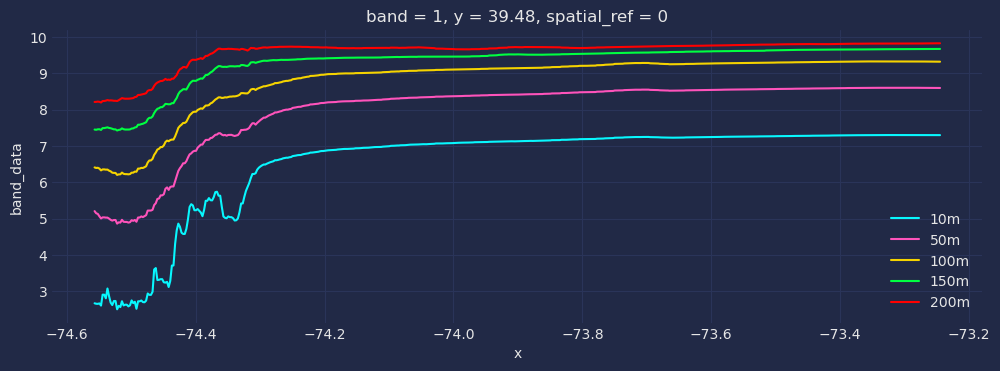

In [23]:
# add 200m windspeed
windspeed200_1d=windspeed200.sel(band=1, y=lat_trans, method='nearest')

windspeed10_1d.plot(label="10m")
windspeed50_1d.plot(label="50m")
windspeed100_1d.plot(label="100m")
windspeed150_1d.plot(label="150m")
windspeed200_1d.plot(label="200m")

plt.legend();

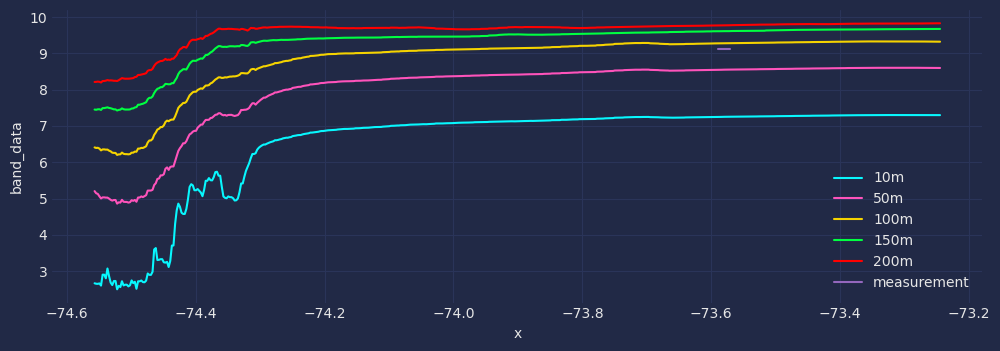

In [24]:
# add measurement data
windspeed_meas_1d=xr.DataArray([data_meas,data_meas], name="band_data",dims={"x"}, coords={"x":[lon_meas,(lon_meas+0.02)]})

windspeed10_1d.plot(label="10m")
windspeed50_1d.plot(label="50m")
windspeed100_1d.plot(label="100m")
windspeed150_1d.plot(label="150m")
windspeed200_1d.plot(label="200m")
windspeed_meas_1d.plot(label="measurement")

plt.legend();

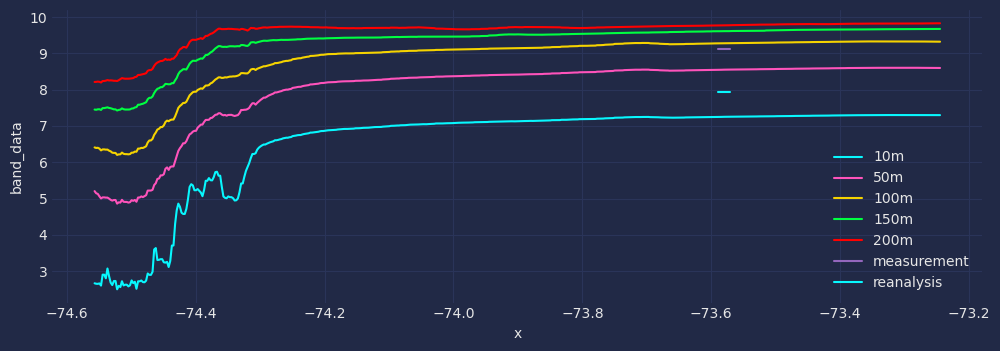

In [25]:
# add reanalysis data
windspeed_rean_1d=xr.DataArray([data_rean,data_rean], name="band_data",dims={"x"}, coords={"x":[lon_meas,(lon_meas+0.02)]})

windspeed10_1d.plot(label="10m")
windspeed50_1d.plot(label="50m")
windspeed100_1d.plot(label="100m")
windspeed150_1d.plot(label="150m")
windspeed200_1d.plot(label="200m")
windspeed_meas_1d.plot(label="measurement")
windspeed_rean_1d.plot(label="reanalysis")

plt.legend();

## Learn to drive before taking off in a Ferrari!

<center><img src="images/openclipart_Ferrari-f458-Spider.svg" width="70%"></center>

## Recap of potential pitfalls and misconceptions...

Points here to recap some of the misconceptions / pitfalls we have highlighted, and other things
* Original data might have isses<br>which get **worse** when propagated through an impact chain...
* other points here
* etc.

## Discussion: Next Generation Climate Services

**todo: agree suggested topics, add to list**

* Talking point 1
* Talking point 2
* Talking point 3
* Talking point 4


[*click here to jump back to the start*](#top)